## Basic Relative Permeability Example in 2D
This example is about finding relative permeability of two phases in the medium. We use invasion percolation to invade air (non-wetting) into a water-filled (wetting) network. Here we use a 2D network so that we can visualize the results easily.

In [1]:
import warnings
import pandas as pd
import scipy as sp
import numpy as np
import openpnm as op
from openpnm import models
import matplotlib.pyplot as plt
np.set_printoptions(precision=4)
np.random.seed(10)
%matplotlib inline
ws = op.Workspace()
ws.settings["loglevel"] = 40

### Initialize Required Objects
We'll use several pre-defined classes here to simplify the example, allowing us to focus on the actual problem of computing relative permeability. Note that each phase is assigned to a separate physics.

In [2]:
shape=[100, 100, 1]
pn = op.network.Cubic(shape)
geo = op.geometry.StickAndBall(network=pn, pores=pn.Ps, throats=pn.Ts)
air = op.phases.Air(network=pn)
water = op.phases.Water(network=pn)
phys_air = op.physics.Standard(network=pn, phase=air, geometry=geo)
phys_water = op.physics.Standard(network=pn, phase=water, geometry=geo)

### Using InvasionPercolation to Simulate Air Invasion
The InvasionPercolation (IP) algorithm will be used to simulaton the air invasion.  We'll inject only from one face (pores on the 'left' side). All settings in IP are set to be default. For instance we don't use trapping options, which is an extra step in IP.

In [3]:
ip = op.algorithms.InvasionPercolation(network=pn)
ip.setup(phase=air)
in_pores=pn.pores("left")
ip.set_inlets(pores=in_pores)
ip.run()

After implementing IP, we usually plot intrusion curves (Pc-S curves) but this is not the scope of this example. Instead we want to visualize the distribution of phases (occupancy of pores and throats) at a specified saturation point. Pore and throat occupancies are defined as boolean arrays in IP with the same length as Pores and throats numbers in the network. For each saturation point (in the range of [0,1]) during the invasion, the pore occupancy shows whether it is occupied by air or water. This is done by assigning a boolean value to the corresponding element in occupancy array. Note that at the beginning (Snwp=0 all pores are occupied by water so all elements are False for air occupancy).
For a desired saturation point (Snwp=0.15) pores and throats occupancies can be accessed by ``results`` method in IP.

In [4]:
occupancies=ip.results(Snwp=0.25)
print(occupancies)

{'pore.occupancy': array([ True,  True,  True, ..., False, False, False]), 'throat.occupancy': array([False, False,  True, ..., False, False, False])}


We can then assign the pores and throats occupancies to the invading phase. Note that in this context occupancy and saturation are two different words. The occupancy here is the distribution of fluid for the specific saturation point (Snwp=0.25 for now). It means 0.15 of void volume is saturated by air and the detail of occupation is found from occupancy distribution.

In [5]:
air.update(ip.results(Snwp=0.25))

Let's plot the occupancies to visualize it.

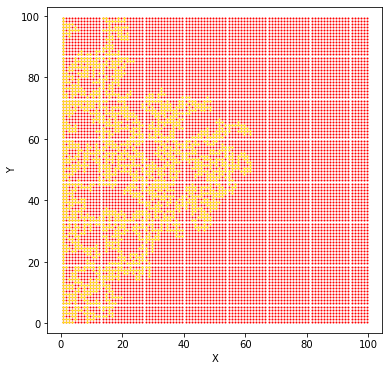

In [6]:
fig = plt.figure(figsize=(6, 6))
fig = op.topotools.plot_coordinates(network=pn, fig=fig)
fig = op.topotools.plot_coordinates(network=pn, fig=fig, 
                                    pores=air['pore.occupancy'], 
                                    color='yellow')

### StokesFlow Algorithm for effective permeabilities
Now that the invasion pattern for this domain has been established using IP, we can calculate the effective and relative permeabilty of the phases at each saturation point using Stokes Flow. Note that relative permeability of air at a specific saturation is the ratio of effective permeability of air while water is also existing (flowing) in the medium to absolute permeability of the medium.

Absolute permeability of a medium with area $A$, and length $L$ can be calculated as following:
$Q_{S=1}=\frac{K_{abs}A}{\mu L}\delta P$ , where $Q$ and $P$ are rate and pressure. $K$ in this equation is the absolute permeability of the medium assuming the medium is fully saturated by a phase with viscosity of $\mu$ (here water). To find the relative permeability of water for example, we need its effective permeability value. The effective permeability value is found in a similar way using stokes flow. The only difference is the medium is saturated with more than 1 phase (here both water and air). Let's write down the equation for water flow when air is invaded:$Q_{S}=\frac{K_{eff} A}{\mu L}\delta P$. Relative permeability of water is then found by: $K_{rel}=\frac{K_{eff}}{K_{abs}}$. From previous equations we then have $K_{rel}=\frac{Q_{S=1}}{Q_{S}}$. Therefore, in this problem we don't need to find $K$ values directly. We just need to calculate the rates. (Note: for air we also need viscosity ratios as $\mu_{air} \ne \mu_{water}$, but here we calculate the absolute rate for each phase separately and viscosity ratio is not required)

Let's first find the rate of water flow for when the medium is fully saturated by water.

In [7]:
st = op.algorithms.StokesFlow(network=pn)
st.setup(phase=water)
st.set_value_BC(pores=pn.pores('front'), values=1)
st.set_value_BC(pores=pn.pores('back'), values=0)

We can solve the flow problem on the netowrk without altering the throat conductances, which will give us the maximum flow through the domain for single phase flow. This value is used for finding absolute permeability as well.

In [8]:
st.run()
Q_abs_water = st.rate(pores=pn.pores('front'))
print(Q_abs_water)

[0.0454]


Next we will illustrate how to alter the hydraulic conductances of the water phase to account for the presence of air filled pores and throats.  Start by passing 'pore.occupancy' and 'throat.occupancy' to the air object at a specified saturation (0.1 in this case), then reach into the ``phys2`` object and set the conductance of the air filled throats to 1000x lower than the least conductive water filled throat. A similar procedure is provided by a pore scale model in Physics.models.multiphase called conduit_conductance, which we could use instead. Note that in that case we use regenerate_models method instead of manually change the hydraulic conductance. This is important because at each saturation point the pore/throat occupancies are different so as their conductance.

In [9]:
air.update(ip.results(Snwp=0.20))
val = np.amin(phys_water['throat.hydraulic_conductance'])/1000
phys_water['throat.hydraulic_conductance'][air['throat.occupancy']] = val

We then re-run the flow problem, which will now utilize the altered hydraulic conductance values.  

In [10]:
st.run()
Q_eff = st.rate(pores=pn.pores('front'))
print(Q_eff)

[0.0454]


Relative permeability of water at saturation point Snwp=0.2 (or Swp=0.8) is:

In [11]:
K_rel_w=Q_eff/Q_abs_water
print(K_rel_w)

[1.]


### Calculate Relative Permeability Curve
The above illustration showed how to get the effective permeability at one saturation.  We now put this logic into a for loop to obtain water flow rates throat the partialy air-invaded network at a variety of saturations.  

Calculations for water phase: Note that we first start with regenerating models for phys_water to make sure the conductance values are reset to the state where medium was fully saturated with water. We then change those values for throats that are occupied by air at each saturation point.

In [12]:
#NBVAL_IGNORE_OUTPUT
phys_water.regenerate_models()  # Regenerate phys2 to reset any calculation done above
Q_water = []  # Initialize a list to hold data
#stokes flow for water
for s in np.arange(0, 1, 0.1):  # Loop through saturations
    # 1: Update air object with occupancy at given saturation
    air.update(ip.results(Snwp=s))
    # 2: Overwrite water's hydraulic conductance in air-filled locations
    phys_water['throat.hydraulic_conductance'][air['throat.occupancy']] = val
    # 3: Re-run flow problem
    st.run()
    # 4: Compute flow through inlet phase and append to data
    Q_water.append(st.rate(pores=pn.pores('front')))
    phys_water.regenerate_models()

Claculations for air phase:

In [13]:
phys_water.regenerate_models()
phys_air.regenerate_models()
Q_air=[]
#stokes flow for air
st_a = op.algorithms.StokesFlow(network=pn)
st_a.setup(phase=air)
st_a.set_value_BC(pores=pn.pores('front'), values=1)
st_a.set_value_BC(pores=pn.pores('back'), values=0)
st_a.run()
Q_abs_air=st_a.rate(pores=pn.pores('front'))
for s in np.arange(0, 1, 0.1):  # Loop through saturations
    # 1: Update air object with occupancy at given saturation
    air.update(ip.results(Snwp=s))
    # 2: Overwrite air's hydraulic conductance in water-filled locations
    phys_air['throat.hydraulic_conductance'][~air['throat.occupancy']] = val
    # 3: Re-run flow problem
    st_a.run()
    # 4: Compute flow through inlet phase and append to data
    Q_air.append(st_a.rate(pores=pn.pores('front')))
    phys_air.regenerate_models()

In [14]:
data = {'Snwp':np.arange(0, 1, 0.1),'Kr_water':np.hstack(Q_water/Q_abs_water),'Kr_air':np.hstack((Q_air/Q_abs_air))} 
DF=pd.DataFrame(data)
DF

,Snwp,Kr_water,Kr_air
0,0.0,1.000000,0.000001
1,0.1,1.000000,0.000001
2,0.2,1.000000,0.000001
3,0.3,0.774782,0.225224
4,0.4,0.674860,0.325148
5,0.5,0.674860,0.325148
6,0.6,0.674860,0.325148
7,0.7,0.366828,0.633187
8,0.8,0.218308,0.781712
9,0.9,0.053850,0.946182


Let's plot the curves. Note that we used less saturation points. To get a smoother plot with more data points decrease the saturation increments (e.g. np.arange(0, 1, 0.01) in the loop).

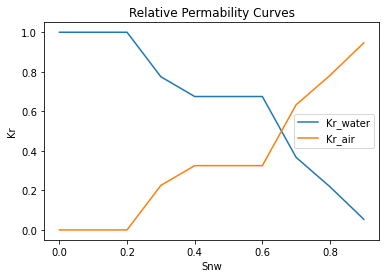

In [15]:
# NBVAL_IGNORE_OUTPUT
f = plt.figure()
ax = f.add_subplot(111)
ax.plot(DF['Snwp'],DF['Kr_water'],label='Kr_water')
ax.plot(DF['Snwp'],DF['Kr_air'],label='Kr_air')
ax.set_xlabel('Snw')
ax.set_ylabel('Kr')
ax.set_title('Relative Permability Curves')
ax.legend()